<a href="https://colab.research.google.com/github/comaraDOTcom/machine-vision/blob/main/classical/Etivity_assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Etivity Assignment 1: Ships in Satellite Imagery
In this assignment we will build & train an object detector to solve the problem of idenifying ships in satellite imagery. 

![link text](https://github.com/tonyscan6003/CE6003/blob/master/images/sat_img1.JPG?raw=true)

This assignment demonstrates that classical image processing techniques may be used in preference to deep learning for certain applications. Particularly those that are limited in computational power or require fast execution. 



This lab uses a [kaggle dataset](https://www.kaggle.com/rhammell/ships-in-satellite-imagery). Please read the [PDF](https://github.com/tonyscan6003/CE6003/blob/master/images/CE6003_kaggle_data_instructions.pdf) detailing how to setup your PC so that you can use a kaggle dataset within Colab.  The dataset contains image patches of ships as well as background images of sea and coastline. 

![Ships in Satellite imagery](https://i.imgur.com/tLsSoTz.png)

This assigment contains all the code necessary to read the downloaded kaggle files and create image and label arrays with test and train splits.




# Dowload Kaggle Dataset.
The following code cells will download the kaggle ship-in-satellite-imagery dataset and unzip the file. (Ensure you have a valid kaggle API token stored on your PC as described in the PDF.)

In [ ]:

! pip install -q kaggle==1.5.6
from google.colab import files
files.upload()

In [2]:
#Choose the kaggle.json file that you downloaded
! mkdir ~/.kaggle
#Make directory named kaggle and copy kaggle.json file there.
! cp kaggle.json ~/.kaggle/
#Change the permissions of the file.
! chmod 600 ~/.kaggle/kaggle.json

# Load dataset
! kaggle datasets download rhammell/ships-in-satellite-imagery

!unzip ships-in-satellite-imagery.zip > /dev/null

 94% 174M/185M [00:01<00:00, 154MB/s]
100% 185M/185M [00:01<00:00, 167MB/s]


#HouseKeeping
 Import packages, helper functions to read from URL and import images.

In [3]:
# install packages
from skimage import feature
from skimage import exposure
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import classification_report
import numpy as np
import glob
import urllib.request
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


def url_to_image(url):
  	resp = urllib.request.urlopen(url)
  	temp_image = np.asarray(bytearray(resp.read()), dtype="uint8")
  	temp_image = cv2.imdecode(temp_image, cv2.IMREAD_COLOR)
  	temp_image = cv2.cvtColor(temp_image, cv2.COLOR_BGR2RGB) # OpenCV defaults to BGR, but we need RGB here..
  	return temp_image

def read_image(image_url):
    image = url_to_image(image_url)
    x,y,z = np.shape(image)
    # Image is scaled to reduce computation time
    image = cv2.resize(image, dsize=(int(y/sf), int(x/sf)), interpolation=cv2.INTER_CUBIC)
    return image

In [4]:
# Read downloaded file list: Files are comprised of positive (ship) and negative (Not ship) examples

pos_img_list = glob.glob('shipsnet/shipsnet/1_*.png')
neg_img_list = glob.glob('shipsnet/shipsnet/0_*.png')
print(f"Number of positive images {np.shape(pos_img_list)}, number of negative images {np.shape(neg_img_list)}")

Number of positive images (1000,), number of negative images (3000,)


# Read Data 
Read data from unzipped downloaded files and create the Training and Test sets. (Note that these are training and test sets of image patches that can be used to train an image classifier)

In [145]:
# Set variables
n = 80 # number of x,y pixels in this image.
n_pts = 4000 # number of points to use (are 4000 in dataset, 1000 positive 3000 negative)

In [146]:
# Function makes images greyscale

def read_images(img_list):
   train_pos = np.empty([1,n*n])
   # Function to read images from file list 
   for i in range(len(img_list)): 
      img_path = img_list[i]
      img = cv2.imread(img_path, cv2.IMREAD_COLOR)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      #  store image as row in array
      train_pos = (np.concatenate((train_pos,np.reshape(img, (1, n*n)))) if i>0 else  np.reshape(img, (1, n*n)))
   return train_pos 

In [147]:
# Read positive and negative shp images into arrays 
pos_img = read_images(pos_img_list)

neg_img = read_images(neg_img_list)


In [148]:
# create corresponding arrays of labels
y_pos_labels = np.ones(len(pos_img_list))
y_neg_labels = np.zeros(len(neg_img_list))

In [149]:
# Combine positive and negative images into one dataset. 
dataset_img = np.concatenate((pos_img[0:1000,:],neg_img[0:3000,:]))
dataset_labels = np.append(y_pos_labels,y_neg_labels)

In [150]:
# Training examples
n_train = int(0.7*n_pts)

# Divide into training and test sets with labels
X_train, X_test, y_train, y_test = train_test_split(dataset_img, dataset_labels, train_size=n_train,
                                                    random_state=0,
                                                    stratify=dataset_labels)

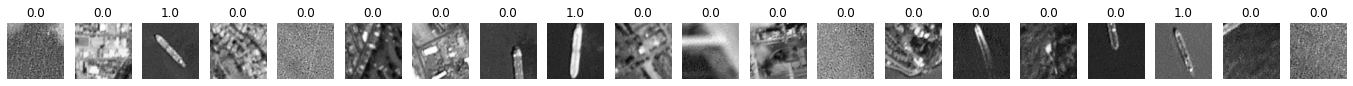

In [151]:
# Plot some examples from the training data
n_plots = 20 # number of plots
f, axarr = plt.subplots(1,n_plots,figsize=(24,24))
for i in range(0,n_plots,1):

   axarr[i].imshow( np.reshape(X_train[i,0:n*n], (n, n)) ,'gray')
   axarr[i].axis('off')
   axarr[i].title.set_text(y_train[i])

#Part 1. Build and Train an Image Classifier
As we have seen in the notes simple object detectors are based on image classifiers trained on image patches. You must choose an appropriate representation for the images and a suitable classifier.

Hints:
> `feature.hog` command from [skimage](https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html). 

>sklearn [list of classifiers](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html)



Using HOG (Histogram of oriented gradients) from the [scikit-image library](https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html). 

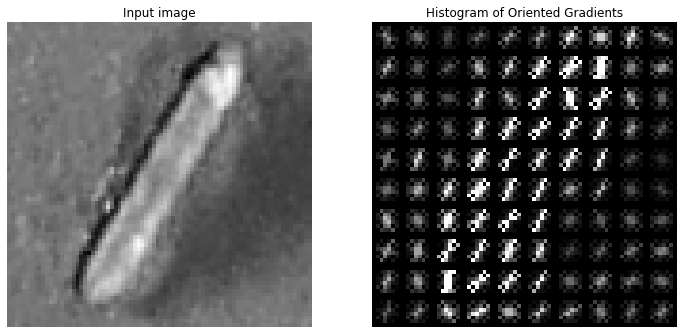

In [152]:

image = np.reshape(X_train[1010,0:n*n], (n, n))


fd, hog_image = feature.hog(image, orientations = 12, pixels_per_cell=(8,8), cells_per_block=(3, 3), visualize=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

In [153]:
def calculate_hog(imgs: np.array, ppc = 16, cpb = 3) -> np.array:
  """
  For each input image in imgs, this function calculates histogram of oriented gradients (HOG), returns the feature
  vector for each image in an array. You can specify the pixels per cell and cells per block. Orientations are 
  fixed to 9.
  :param imgs: array of images
  :param ppc: pixel per cell
  :param cpb: cells per block
  :return: array
  """
  # dimensions of fd this will be (floor(n/pixels_per_cell))**2 * orientation
  for i in range(imgs.shape[0]):
    image = np.reshape(imgs[i,0:n*n], (n, n))
    blur_image = cv2.GaussianBlur(image,(5,5),0)
    fd = feature.hog(blur_image, pixels_per_cell=(ppc,ppc), cells_per_block=(cpb, cpb), visualize=False)
    if i == 0:
      # instantiate the array for the first image.  
      feature_matrix = np.array([fd])
    else:
      feature_matrix = np.vstack([feature_matrix, fd])
  return feature_matrix  

In [154]:
# Calculate HOG for all the images (create the train and test set)
X_train_hog = calculate_hog(X_train)
X_test_hog = calculate_hog(X_test)

In [155]:
# Train a sklearn classifier using X_train_hog. 
# I've chosen a Gaussian Process Classifier in this case (this was covered in Etivity3 in ET5003)
kernel = 1.0 * RBF(1.0)
gpc = GaussianProcessClassifier(kernel=kernel, random_state=0).fit(X_train_hog, y_train)

In [156]:
# Get score on the training dataset.
gpc.score(X_train_hog, y_train)

1.0

In [157]:
# Make predictions on the testing dataset.
y_pred = gpc.predict(X_test_hog)

Test performance of your classifier using the test dataset and obtain a [classification report](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-report).

You can plot some examples from the test set using the function in the cell below.  

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       900
         1.0       0.98      0.98      0.98       300

    accuracy                           0.99      1200
   macro avg       0.99      0.99      0.99      1200
weighted avg       0.99      0.99      0.99      1200



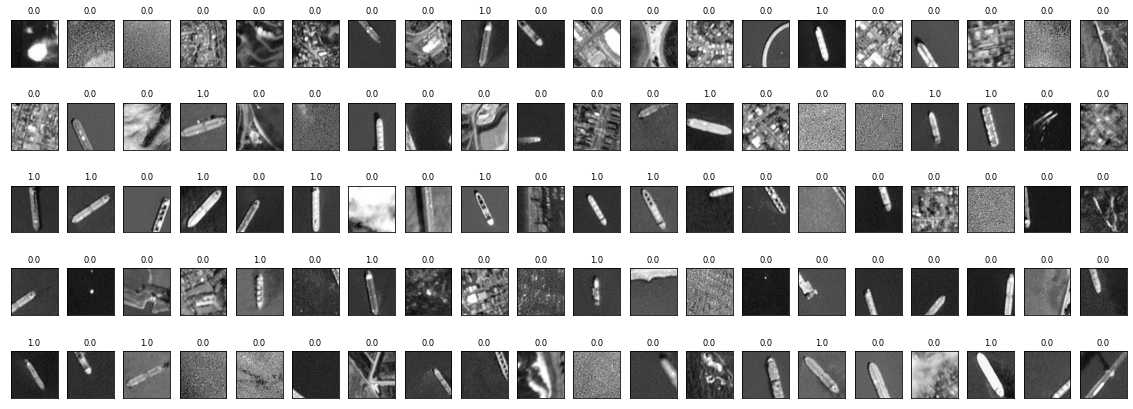

In [158]:
# Using the provided classification report code
print(classification_report(y_test, y_pred))

def plot_examples(y_pred,y_test):
   n_plots = 30 # number of plots
   fig = plt.figure(figsize=(20, 15))
   for i in range(100):
      ax = fig.add_subplot(10, 20, i + 1, xticks=[], yticks=[])
      ax.imshow( np.reshape(X_test[i,0:n*n], (n, n)) ,'gray')
      color = ('black' if y_pred[i] == y_test[i] else 'red')
      ax.set_title(y_test[i],
                 fontsize='small', color=color)
      
plot_examples(y_pred,y_test) 

In [159]:
# creating list of tuples (alias and instantiate the model) 
models = []
models.append(('GNB',GaussianNB()))
models.append(('KNN',KNeighborsClassifier()))
models.append(('DT',DecisionTreeClassifier()))
models.append(('RF',RandomForestClassifier()))
models.append(('GPC', GaussianProcessClassifier(kernel=kernel, random_state=0)))
models.append(('SVC',SVC()))

In [160]:
acc = []   # list for collecting Accuracy of all model
names = []    # List of model name

for name, model in models:
    
    acc_of_model = cross_val_score(model, X_train_hog, y_train, cv=5, scoring='accuracy')
    
    # appending Accuray of different model to acc List
    acc.append(acc_of_model)
    
    # appending name of models
    names.append(name)
    
    # printing Output 
    Out = "%s: %f" % (name, acc_of_model.mean())
    print(Out)

GNB: 0.919643
KNN: 0.970714
DT: 0.924286
RF: 0.969643
GPC: 0.990714
SVC: 0.992857


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


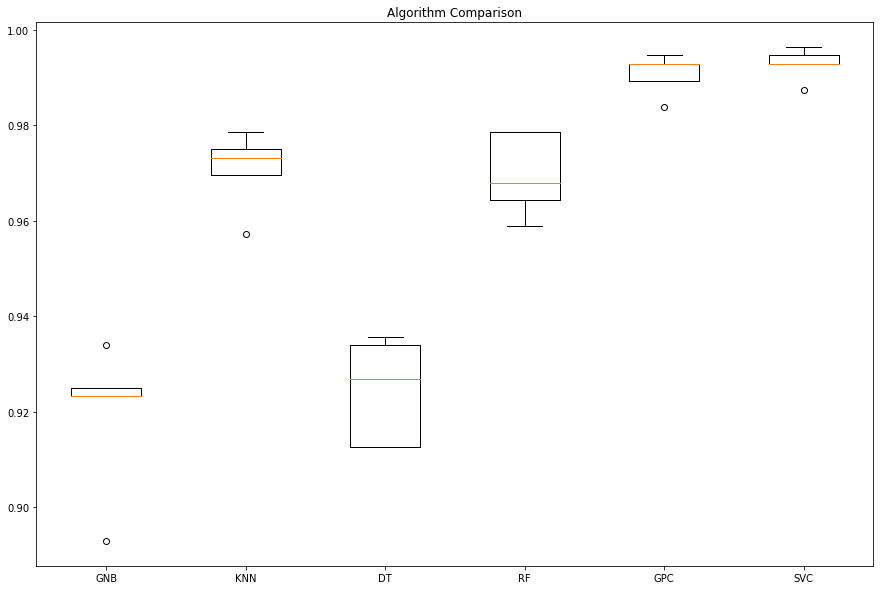

In [161]:
fig = plt.figure(figsize=(15, 10))
plt.title('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(acc)
ax.set_xticklabels(names)
plt.show()

# 2. Use the Classifier as a basic Object Detector 

**Import scene:** We want to use the classifier to perform object detection of ships in the high resolution satellite image scene imported in the code cell below. You can use grey scale version of the image gray_img in your detector, bounding boxes marking the locations of the ships can be applied to the colour version of the image.

*Coordinate Systems*

> The greyscale input image that we are applying our sliding window detector to is a matrix. The elements of this matrix are accessed as (row,column). In order to successfully plot the bouding box using OpenCV rectangle commands, the bounding boxes must be output in a format [x1,y1,x2,y2] where x1,y1 correspond to the top left hand side corner of the bouding box and x2,y2 the bottom right corner. Thus the x coordinate of the bounding box corresponds to the column of the matrix and the y coordinate the rows. The origin (0,0) in the coordinate system used by OpenCV is the top left of the image.

*Non Maximal Supression*

>  We can use the `non_max_supression` function from the `imutils` package to remove overlapping detections. (This is already implemented in a spearate code cell (see below) that displays the bouding boxes you find)  






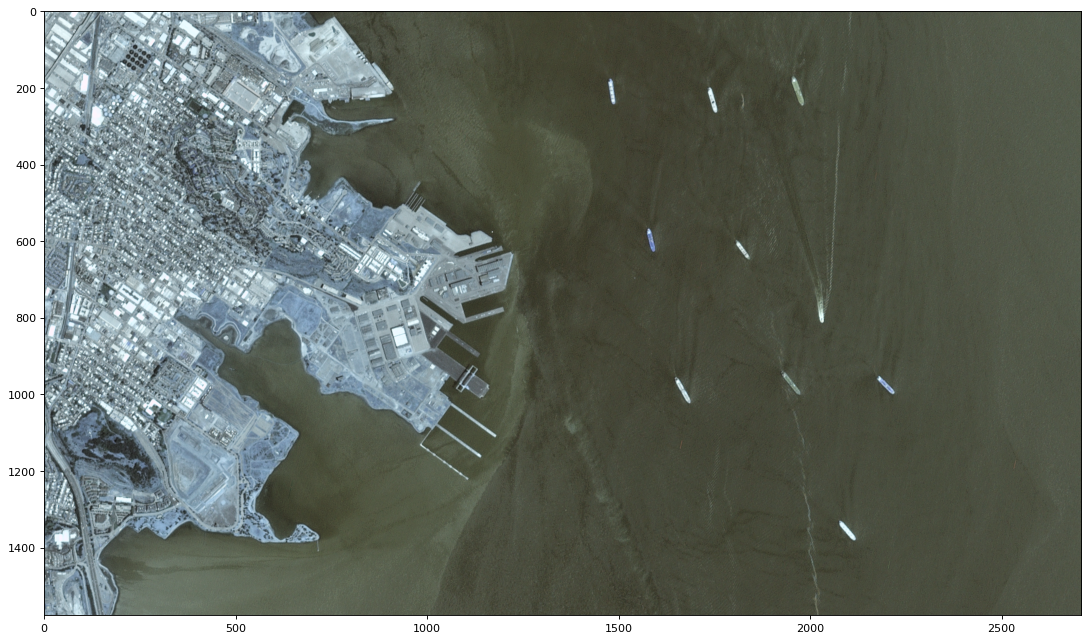

In [162]:
# Load and Display Secene to perform Object Detection on
img_path = 'scenes/scenes/sfbay_3.png'
col_img = cv2.imread(img_path, cv2.IMREAD_COLOR)
gray_img = cv2.cvtColor(col_img, cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(18, 10), dpi=80)
plt.imshow(col_img, aspect='auto') 
plt.imshow( col_img ,'gray')
plt.show()



## Your Work Here......
You can write code for the object detector that uses the classifier you previously developed in the code cell below:

The output of your object detector should be an array called "found_boxes" that is m x 4 array of output bounding boxes.
Each row corresponds to a bounding box [x1,y2,x2,y2] (see note on coordinate system above)








In [167]:
def slide_window_over_image(image_to_detect_from, slider_step = 10, n=80) -> np.array:
  """
  This function slides a window over `image_to_detect_from` by moving the slider
  in increments of `slider_step` across the x and y axis until the who image is covered.
  For each 
  :param image_to_detect_from: grayscale numpy array image to detect object from.
  :param slider_step: increments in pixels to move the window across the image.
  """
  height, width = image_to_detect_from.shape

  found_boxes = []
# increasing x and y in increments of the slider step pixels
  for y in range(0, height, slider_step):
    for x in range(0, width, slider_step):
      # add length and width of n (this image size the image classifier was trained on)
      window_height = y + n
      window_width = x + n

      if (window_height < height and window_width < width):
        img = image_to_detect_from[y:window_height, x:window_width]

        if (img.shape[0] == n and img.shape[1] == n):
          img_hog = calculate_hog(np.reshape(img, (1, n*n)), ppc=16)
          predict_ship_class = gpc.predict(img_hog)

          if (predict_ship_class):
             found_boxes.append([x,y,window_width,window_height])
  return np.array(found_boxes)

In [168]:
found_boxes = slide_window_over_image(gray_img)

The non_max_supression function from the imutils package can be used to remove overlapping boxes. The boxes are overlaid on the color version of the satellite image. The function operates on the "found boxes" vector that is output by your object detector.

The overlap threshold can be adjusted, this value determines how much overlap is required before detections are considered to be from the same object. (A high threshold will return more detections)  

Before suppression, we had 88 bounding boxes, after suppression we have 24


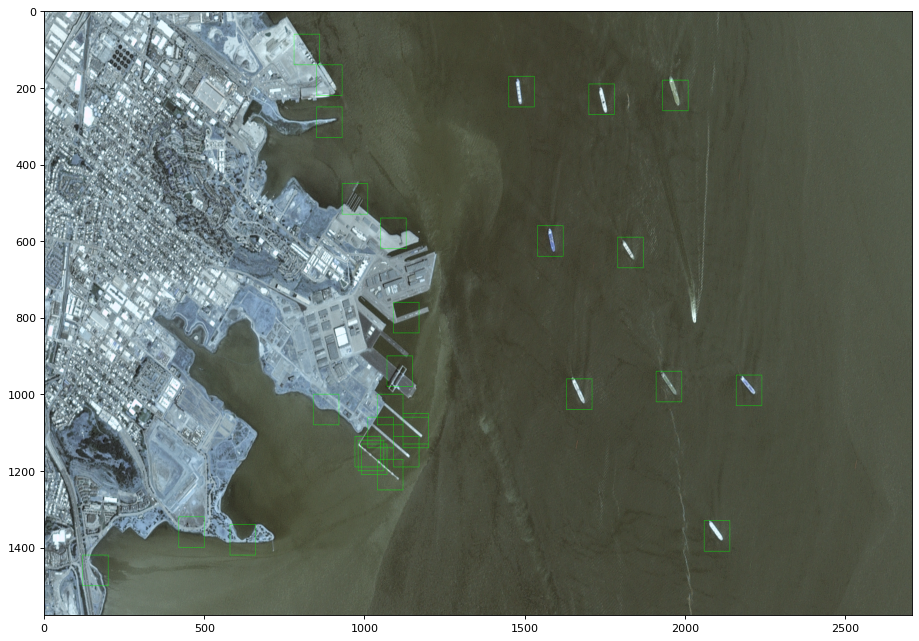

In [171]:
from imutils.object_detection import non_max_suppression

#Bounding box parameters
greenColor = (0, 255, 0)
lineThickness = 4

# run non-max suppression on these based on an overlay op 65%
nmsBoundingBoxes = non_max_suppression(found_boxes, probs=None, overlapThresh=0.05)

print ("Before suppression, we had {} bounding boxes, after suppression we have {}".format(len(found_boxes), len(nmsBoundingBoxes)))

greenColor = (0, 255, 0)
lineThickness = 1
# draw the final bounding boxes
for (xA, yA, xB, yB) in nmsBoundingBoxes:
    cv2.rectangle(col_img, (xA, yA), (xB, yB), greenColor, lineThickness)

# Plot figures
plt.figure(figsize=(14, 10), dpi=80)
plt.imshow(col_img, aspect='auto') 
plt.show()

## Summary

### Image Classification Performance
Performance definitely increased with the addition of a [Gaussian blur filter](https://en.wikipedia.org/wiki/Gaussian_blur). The classification accuracy metric increased about 3% with the addition of this. The performance of the image on classification was strong across precision, recall, f1-score and accuracy.

Different models that were trained on 5 fold cross-validation

| Model                       | Accuracy |
|-----------------------------|----------|
| Gaussian naive Bayes        | 0.910000 |
| K Nearest Neighbours        | 0.959286 |
| Decision Tree               | 0.878929 |
| Random Forest Classifier    | 0.951786 |
| Gaussian Process Classifier | 0.963929 |
| Support Vector Classifier   | 0.971786 |

For the training and prediction of the test data, the Gaussian Process Classifier was chosen as the model (the main draw back of this was its long training time - however not parameter space search was required).


### Finding a suitable parameter configuration for Hog
Very slow training times for the Gaussian Process classifier were experienced. In order to combat this, the config for `skimage.feature.hog()` was changed a few times from having `pixels_per_cell = 8` to become `16`, this reduced training time substaintailly (Thanks to @Anthony Purcell for his comment on his post that this improved reducing false positives for him).

 The argument `cells_per_block = 1` performed very poorly at classifying a very high number of false positive ships, increased it to `cell_per_block = 3` change which reduced the number of false postivies and increases validation metric scores. The `orientation` was bumped up from `9` to be `12` for training, this improved validation scores too.

 Final `hog` parameter configuation was `(orientation = 12, pixels_per_cell = (16,16), cell_per_block = (3,3))`.

### Object detection
Initial object detection of the trained Image classifier resulted in a very high number of false positives and relatively close overlapping prediction squares. This seemed to be due to the `cell_per_block = 1` feature. Once this was increased up to `3`, the number of false positives decreased.

Upon training the model and seeing the results, it looks like all ships were correctly classified (the small speed boat being the only exception - which probably is different to the training data which focused on large ships as data samples). However the performance of this model did create quite a few false postivies as what expected from the e-tivity brief and I could not manage to eliminate them with the GPC model I chose. Perhaps this is either the limitation of the classical approach to object detection, or else it could be with my model training.


### Further improvements
More image pre-processing or image augmentation to enhance the differences between the ships and land based piers/buildings could've focused on corner edges,  something like the Laplacian kernel could've highglighted the land to water boundarys composed with a Harris corner detection to detect the 4 corners of a ships. Perhaps a bigger window might've been needed to properly notice the ships to include all 4 corners.